## Main Triode Class

In [6]:
import numpy as np
import pickle
from scipy.optimize import curve_fit, least_squares, root_scalar
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.interpolate import griddata, RBFInterpolator, LinearNDInterpolator
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Define Triode class
class Triode:
    def __init__(self, Vp_data, Ia_data, Vg_data):
        self.Vp_data = Vp_data
        self.Ia_data = Ia_data
        self.Vg_data = Vg_data
    def three_D_manifold(self):
        # Step 2: Create interpolation grid
        self.Vp_grid, self.Vg_grid = np.meshgrid(
            np.linspace(min(self.Vp_data), max(self.Vp_data), 100),
            np.linspace(min(self.Vg_data), max(self.Vg_data), 100)
        )
        
        # Step 3: Interpolate current values over the grid
        self.Ia_grid = griddata(
            points=(self.Vp_data, self.Vg_data),
            values=self.Ia_data,
            xi=(self.Vp_grid, self.Vg_grid),
            method='linear'  # can try 'linear' or 'nearest' if sparse
        )
    def plot_three_D_manifold(self):
        # Step 4: Plot the surface
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(self.Vp_grid, self.Vg_grid, self.Ia_grid, cmap='viridis', linewidth=0, antialiased=True)
        
        ax.set_xlabel('Plate Voltage Vp (V)')
        ax.set_ylabel('Grid Voltage Vg (V)')
        ax.set_zlabel('Plate Current Ia (mA)')
        ax.set_title('Interpolated Plate Curve Surface')
        plt.tight_layout()
        plt.show()

    def load_line(self, B_plus, cathode_resist, plate_current, pk_pk, anode_resist):
        self.B_plus = B_plus
        self.anode_resist = anode_resist # defines load line
        self.cathode_resist = cathode_resist # defines op point
        self.plate_current = plate_current
        self.pk_pk = pk_pk
        self.max_current = (self.B_plus / self.anode_resist) * 1000 # b
        self.load_m = -self.max_current / self.B_plus # m
        self.Vg = -(self.plate_current / 1000) * self.cathode_resist
        
    def plot_load_line(self):
        # Plotting
        plt.figure(figsize=(10, 6))

        points_grid = np.column_stack((self.Vp_grid.ravel(), self.Vg_grid.ravel()))
        values = self.Ia_grid.ravel()
        points_data = np.column_stack((Vp_data, Vg_data))
        interp = LinearNDInterpolator(points_data, self.Ia_data)
        Vp_query = np.linspace(points_grid[:, 0].min(), points_grid[:, 0].max(), 500)

        # Traced from data sheet
        for Vg_target in np.unique(self.Vg_data):            
            # Create the query points at this fixed grid voltage
            query_points = np.column_stack([Vp_query, np.full_like(Vp_query, Vg_target)])
            
            # Interpolate using griddata
            Ia_interp = griddata(points_grid, values, query_points, method='linear')
            
            # Plot the result
            plt.plot(Vp_query, Ia_interp, label=f"Interpolated Ia at Vg = {Vg_target}V")
                    
        # Plot load line
        y = self.load_m * Vp_query + self.max_current # y = mx + b
        plt.plot(Vp_query, y, label = "Load line", color='red', linestyle='--')
        
        # Plot operating point
        pseudo_Vp_op = (self.plate_current - self.max_current) / self.load_m # y = mx + b
        plt.plot(pseudo_Vp_op, self.plate_current, color='red', marker='o', linestyle = "none")
        
        # Plot maximum dissipation
        max_diss = 1.2 # Watts
        plt.plot(Vp_query, [max_diss * 1000 / i for i in Vp_query], label = "Max dissipation", color='black', linestyle='--')

        # Define swing
        Vg_swing = np.linspace(self.Vg - self.pk_pk / 2, self.Vg + self.pk_pk / 2, 100)
        Vp_scan = np.linspace(self.Vp_data.min(), self.Vp_data.max(), 1000)
        
        # Bracket finder
        def find_bracket(Vg, interp, Vp_scan):
            for i in range(len(Vp_scan) - 1):
                vp1, vp2 = Vp_scan[i], Vp_scan[i + 1]
                ia1, ia2 = interp(vp1, Vg), interp(vp2, Vg)
                if None in (ia1, ia2) or np.isnan(ia1) or np.isnan(ia2):
                    continue
                res1 = ia1 - (self.B_plus - vp1) / self.anode_resist * 1e3
                res2 = ia2 - (self.B_plus - vp2) / self.anode_resist * 1e3
                if res1 * res2 < 0:
                    return vp1, vp2
            return None, None
        
        # Solve for Vp over swing
        Vp_output = []
        for Vg in Vg_swing:
            def residual(Vp):
                Ia = interp(Vp, Vg)
                if Ia is None or np.isnan(Ia):
                    return 1e6
                return Ia - (self.B_plus - Vp) / self.anode_resist * 1e3
        
            vp_lo, vp_hi = find_bracket(Vg, interp, Vp_scan)
            if vp_lo is not None:
                try:
                    sol = root_scalar(residual, bracket=[vp_lo, vp_hi], method='brentq')
                    Vp_output.append(sol.root if sol.converged else np.nan)
                except ValueError:
                    print(f"Root solve failed for Vg = {Vg:.2f}")
                    Vp_output.append(np.nan)
            else:
                print(f"No bracket found for Vg = {Vg:.2f}")
                Vp_output.append(np.nan)
        
        Vp_output = np.array(Vp_output)
        Ia_output = (self.B_plus - Vp_output) / self.anode_resist * 1e3
        plt.plot(Vp_output, Ia_output, "r-")
        
        plt.xlabel('Plate Voltage Vp (V)')
        plt.ylabel('Plate Current Ia (mA)')
        plt.xlim([0, 500])
        plt.ylim([0, 4])
        plt.title('Triode Plate Curves — 12AX7')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Rebuild 3D grid for surface plot
        Vp_lin = np.linspace(Vp_data.min(), Vp_data.max(), 100)
        Vg_lin = np.linspace(Vg_data.min(), Vg_data.max(), 100)
        Vp_grid, Vg_grid = np.meshgrid(Vp_lin, Vg_lin)
        Ia_grid = interp(Vp_grid, Vg_grid)
        
        # Animate
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(Vp_grid, Vg_grid, Ia_grid, cmap='viridis', alpha=0.6)
        ax.set_xlabel("Plate Voltage Vp (V)")
        ax.set_ylabel("Grid Voltage Vg (V)")
        ax.set_zlabel("Plate Current Ia (mA)")
        ax.set_title("12AX7 Plate Curves with Animated Load Line Swing (Root Scalar, Vg fixed)")
        #ax.view_init(elev=30, azim=135)
        
        line, = ax.plot([], [], [], 'r-', linewidth=3)
        point, = ax.plot([], [], [], 'ro')
        
        def init():
            line.set_data([], [])
            line.set_3d_properties([])
            point.set_data([], [])
            point.set_3d_properties([])
            return line, point
        
        def animate(i):
            #print(f"Frame {i}: Vg = {Vg_swing[i]:.2f}, Vp = {Vp_output[i]}, Ia = {Ia_output[i]}")
            line.set_data(Vp_output[:i+1], Vg_swing[:i+1])
            line.set_3d_properties(Ia_output[:i+1])
            point.set_data([Vp_output[i]], [Vg_swing[i]])
            point.set_3d_properties([Ia_output[i]])
            return line, point
        
        ani = animation.FuncAnimation(fig, animate, init_func=init,
                                      frames=len(Vg_swing), interval=50, blit=True)
        
        ani.save("triode_voltage_swing.gif", writer='pillow', fps=20)
        print("Animation saved as triode_voltage_swing.gif")
        
    def ccs_load_line(self, plate_voltage, plate_current, pk_pk, output_impede=None):
        self.plate_voltage = plate_voltage
        self.plate_current = plate_current
        self.pk_pk = pk_pk
        self.output_impede = output_impede if output_impede else 1e12  # Infinite CCS
        interp = LinearNDInterpolator(np.column_stack((self.Vp_data, self.Vg_data)), self.Ia_data)

        # Robust Vg solver
        def residual_vg(Vg):
            Ia = interp(self.plate_voltage, Vg)
            return 1e6 if Ia is None or np.isnan(Ia) else Ia - self.plate_current

        Vg_scan = np.linspace(min(self.Vg_data), max(self.Vg_data), 500)
        bracket_found = False
        self.Vg = None

        for i in range(len(Vg_scan) - 1):
            vg1, vg2 = Vg_scan[i], Vg_scan[i+1]
            try:
                f1, f2 = residual_vg(vg1), residual_vg(vg2)
                if np.sign(f1) != np.sign(f2):
                    sol = root_scalar(residual_vg, bracket=[vg1, vg2], method='brentq')
                    if sol.converged:
                        self.Vg = sol.root
                        bracket_found = True
                        break
            except:
                continue

        if not bracket_found:
            print("Could not find valid bracket for solving Vg. Using fallback.")
            Ia_interp_vals = np.array([interp(self.plate_voltage, vg) for vg in Vg_scan])
            diff = np.abs(Ia_interp_vals - self.plate_current)
            best_idx = np.argmin(diff)
            self.Vg = Vg_scan[best_idx]

    def plot_ccs_load_line(self):
        interp = LinearNDInterpolator(np.column_stack((self.Vp_data, self.Vg_data)), self.Ia_data)
        plt.figure(figsize=(10, 6))
        Vp_query = np.linspace(min(self.Vp_data), max(self.Vp_data), 500)

        for vg in sorted(np.unique(self.Vg_data)):
            Ia_curve = interp(Vp_query, vg)
            if Ia_curve is not None:
                plt.plot(Vp_query, Ia_curve, label=f"Vg = {vg:.1f} V")

        # Load line
        load_line = self.plate_current - Vp_query / self.output_impede
        plt.plot(Vp_query, load_line, 'r--', label=f"CCS Load (R_out = {int(self.output_impede)} Ω)")

        # Voltage swing
        Vg_swing = np.linspace(self.Vg - self.pk_pk / 2, self.Vg + self.pk_pk / 2, 100)
        Vp_scan = np.linspace(min(self.Vp_data), max(self.Vp_data), 1000)
        Vp_output = []

        for Vg in Vg_swing:
            def residual(Vp):
                Ia = interp(Vp, Vg)
                return 1e6 if Ia is None or np.isnan(Ia) else Ia - (self.plate_current - Vp / self.output_impede)

            found = False
            for i in range(len(Vp_scan) - 1):
                vp1, vp2 = Vp_scan[i], Vp_scan[i + 1]
                try:
                    if np.sign(residual(vp1)) != np.sign(residual(vp2)):
                        sol = root_scalar(residual, bracket=[vp1, vp2], method='brentq')
                        if sol.converged:
                            Vp_output.append(sol.root)
                            found = True
                            break
                except:
                    continue
            if not found:
                Vp_output.append(np.nan)

        Vp_output = np.array(Vp_output)
        Ia_output = self.plate_current - Vp_output / self.output_impede

        # Plot swing
        plt.plot(Vp_output, Ia_output, 'r-', label="Voltage Swing Path")
        valid = np.where(~np.isnan(Vp_output))[0]
        if len(valid) > 0:
            plt.plot(Vp_output[valid[0]], Ia_output[valid[0]], 'go', label="Swing Start")
            plt.plot(Vp_output[valid[-1]], Ia_output[valid[-1]], 'mo', label="Swing End")

        plt.xlabel("Plate Voltage Vp")
        plt.ylabel("Plate Current Ia (mA)")
        plt.title("Voltage Swing with CCS and Finite Output Impedance")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Rebuild 3D grid for surface plot
        Vp_lin = np.linspace(Vp_data.min(), Vp_data.max(), 100)
        Vg_lin = np.linspace(Vg_data.min(), Vg_data.max(), 100)
        Vp_grid, Vg_grid = np.meshgrid(Vp_lin, Vg_lin)
        Ia_grid = interp(Vp_grid, Vg_grid)
        
        # Animate
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(Vp_grid, Vg_grid, Ia_grid, cmap='viridis', alpha=0.6)
        ax.set_xlabel("Plate Voltage Vp (V)")
        ax.set_ylabel("Grid Voltage Vg (V)")
        ax.set_zlabel("Plate Current Ia (mA)")
        ax.set_title("12AX7 Plate Curves with Animated Load Line Swing (Root Scalar, Vg fixed)")
        #ax.view_init(elev=30, azim=135)
        
        line, = ax.plot([], [], [], 'r-', linewidth=3)
        point, = ax.plot([], [], [], 'ro')
        
        def init():
            line.set_data([], [])
            line.set_3d_properties([])
            point.set_data([], [])
            point.set_3d_properties([])
            return line, point
        
        def animate(i):
            #print(f"Frame {i}: Vg = {Vg_swing[i]:.2f}, Vp = {Vp_output[i]}, Ia = {Ia_output[i]}")
            line.set_data(Vp_output[:i+1], Vg_swing[:i+1])
            line.set_3d_properties(Ia_output[:i+1])
            point.set_data([Vp_output[i]], [Vg_swing[i]])
            point.set_3d_properties([Ia_output[i]])
            return line, point
        
        ani = animation.FuncAnimation(fig, animate, init_func=init,
                                      frames=len(Vg_swing), interval=50, blit=True)
        
        ani.save("triode_ccs_voltage_swing.gif", writer='pillow', fps=20)
        print("Animation saved as triode_voltage_swing.gif")

print("Done")

Done


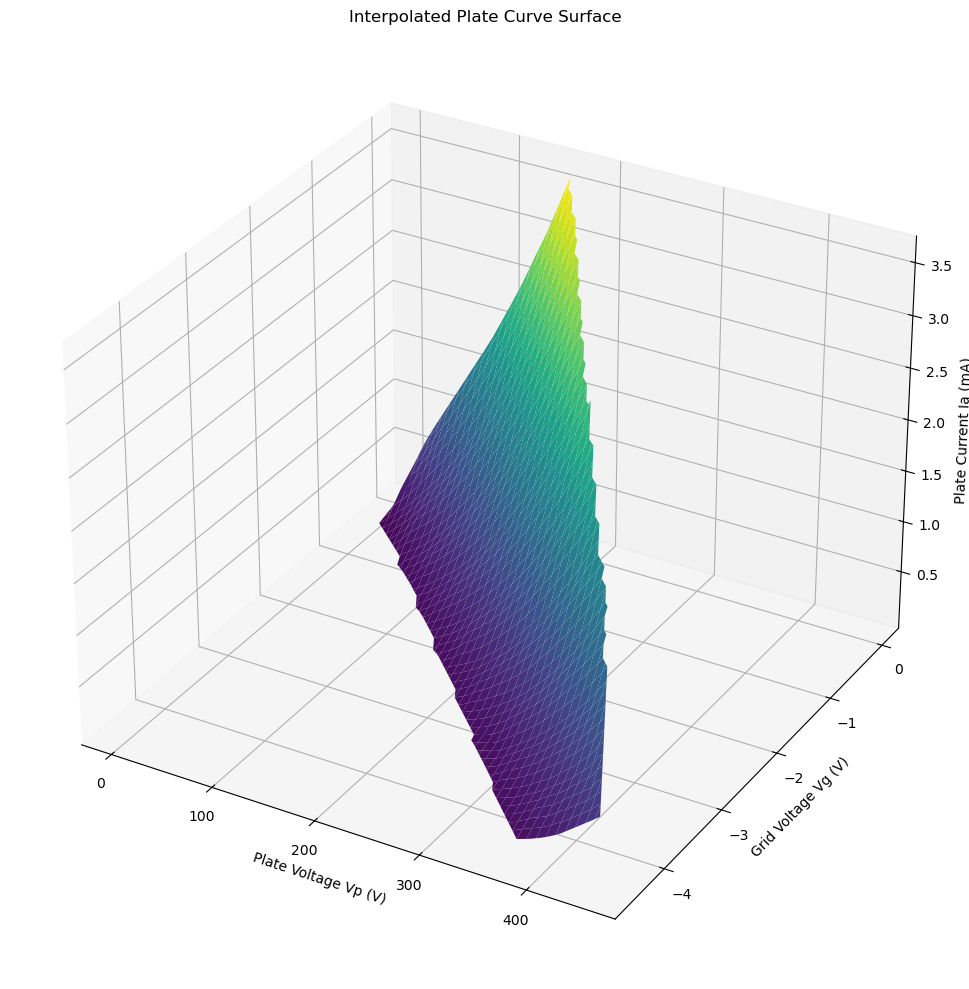

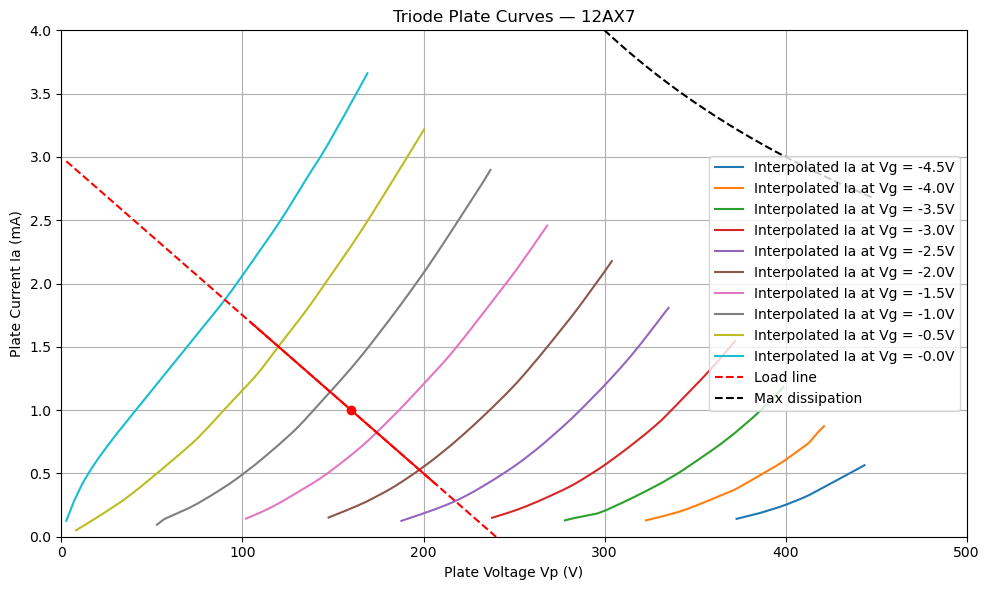

Animation saved as triode_voltage_swing.gif


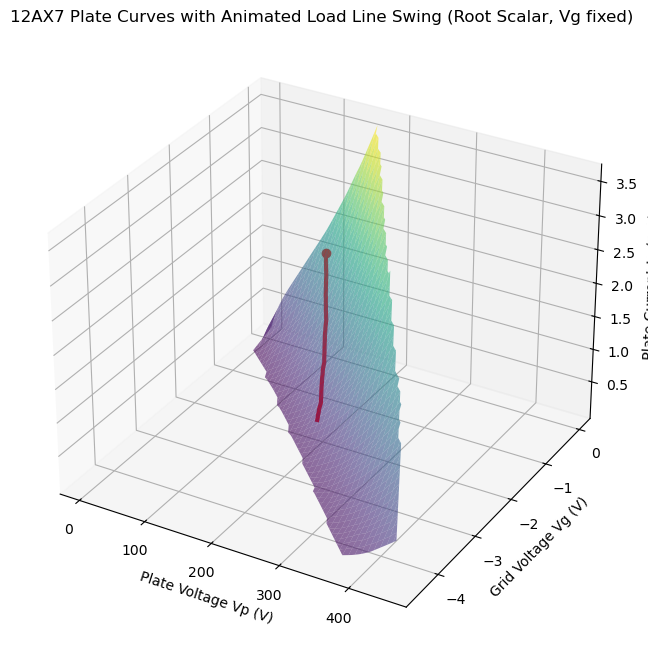

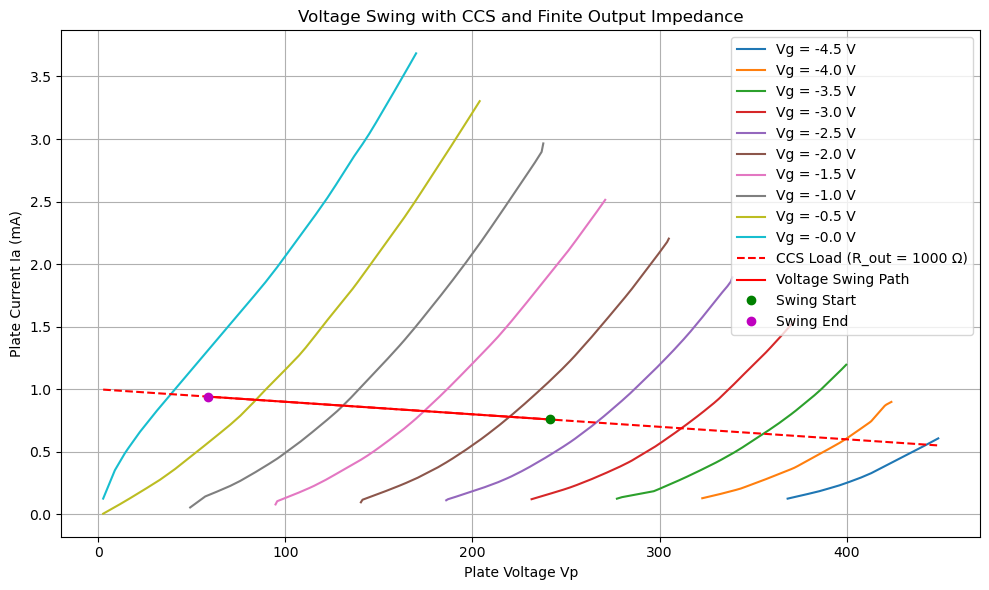

Animation saved as triode_voltage_swing.gif


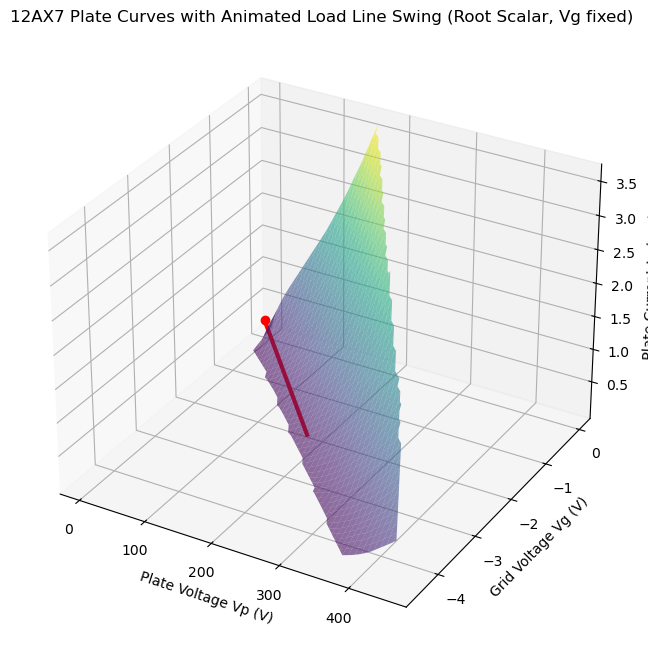

In [7]:
# Load CSV data
df = pd.read_csv("12AX7_plate_curves.csv")

# Flip grid voltages negative (fix)
df["Vg"] = -np.abs(df["Vg"])

Vp_data = df["Vp"].values
Vg_data = df["Vg"].values
Ia_data = df["Ia"].values

Vp_data = np.array(Vp_data)
Vg_data = np.array(Vg_data)
Ia_data = np.array(Ia_data)

triode = Triode(Vp_data, Ia_data, Vg_data)
triode.three_D_manifold()
triode.plot_three_D_manifold()
triode.load_line(240, 1250, 1, 2, 80000) # plate_current in milliamps
triode.plot_load_line()
triode.ccs_load_line(150, 1, 2, 1000)
triode.plot_ccs_load_line()

## Main Pentode Class

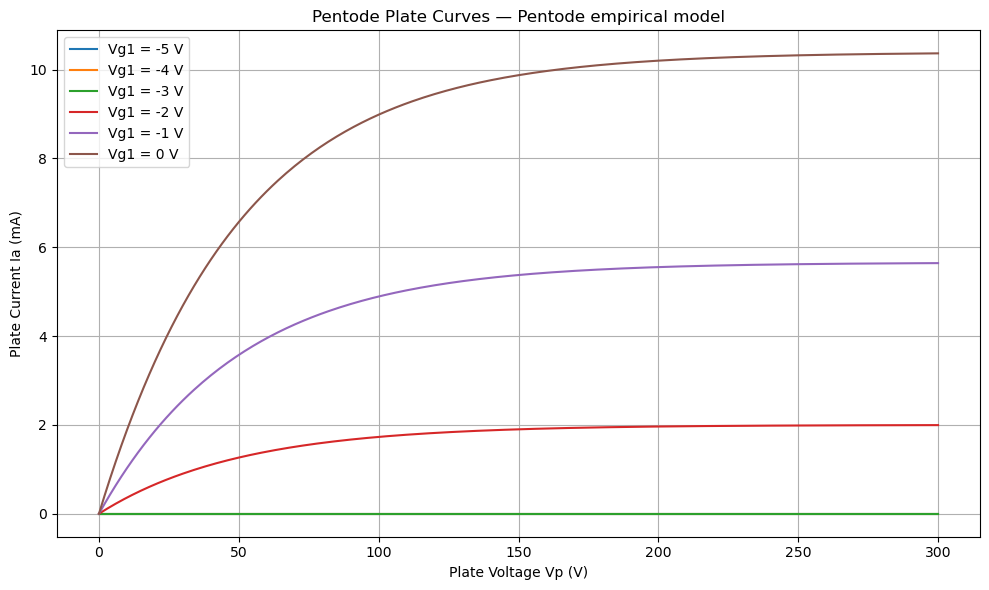

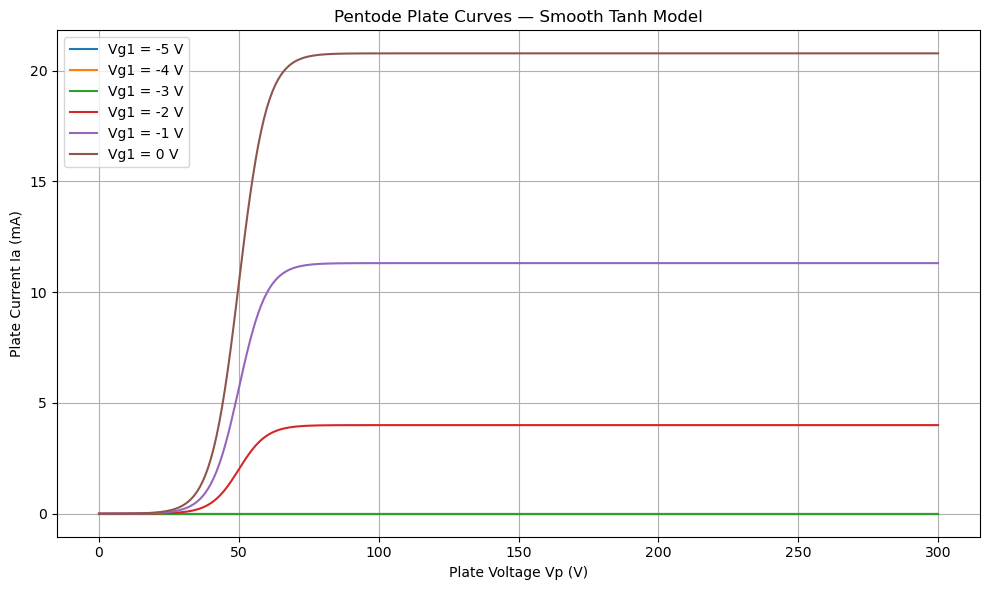

In [4]:
class CustomError(Exception):
    def __init__(self, message="An error occurred", detail=None):
        super().__init__(message)
        self.detail = detail

    def __str__(self):
         return f"{super().__str__()} (Details: {self.detail})" if self.detail else super().__str__()

class Pentode:
    def __init__(self, Vp, Vg_list, Vg2, I0, Vg2_0, Vcut, alpha, beta, Vsat = None, Vknee = None, Vslope = None):
        self.Ip = []
        for Vg1 in Vg_list:
            if Vsat and not (Vknee and Vslope):
                # Pentode empirical model
                Vg1_eff = np.maximum(Vg1 - Vcut, 0)
                term1 = (Vg2 / Vg2_0) ** alpha
                term2 = Vg1_eff ** beta
                term3 = 1 - np.exp(-Vp / Vsat)
                self.Ip.append(I0 * term1 * term2 * term3)
            elif (Vknee and Vslope) and not Vsat:
                # Smoothed pentode model with tanh knee transition
                Vg1_eff = np.maximum(Vg1 - Vcut, 0)
                I_sat = I0 * (Vg2 / Vg2_0)**alpha * Vg1_eff**beta
                transition = 1 - np.tanh((Vknee - Vp) / Vslope)
                self.Ip.append(I_sat * transition)
            else:
                optionals = {"Vsat": Vsat, "Vknee": Vknee, "Vslope": Vslope}
                [print(key) for key, value in optionals.items() if value is None]
                raise CustomError("Missing values", detail="Missing either " + str([key for key, value in optionals.items() if value is None]))
                
Vg2=150
I0=2.0
Vg2_0=150
Vcut=-3.0
alpha=1.0
beta=1.5
Vsat=50

# Voltage Sweep
Vp = np.linspace(0, 300, 301)
Vg1_list = [-5, -4, -3, -2, -1, 0]
pentode = Pentode(Vp, Vg1_list, Vg2, I0, Vg2_0, Vcut, alpha, beta, Vsat = Vsat)

# Plotting
plt.figure(figsize=(10, 6))
for Vg1, Ip in zip(Vg1_list, pentode.Ip):
    plt.plot(Vp, Ip, label=f'Vg1 = {Vg1} V')

plt.xlabel('Plate Voltage Vp (V)')
plt.ylabel('Plate Current Ia (mA)')
plt.title('Pentode Plate Curves — Pentode empirical model')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Vknee=50
Vslope=10
pentode = Pentode(Vp, Vg1_list, Vg2, I0, Vg2_0, Vcut, alpha, beta, Vknee = Vknee, Vslope = Vslope)

# Plotting
plt.figure(figsize=(10, 6))
for Vg1, Ip in zip(Vg1_list, pentode.Ip):
    plt.plot(Vp, Ip, label=f'Vg1 = {Vg1} V')

plt.xlabel('Plate Voltage Vp (V)')
plt.ylabel('Plate Current Ia (mA)')
plt.title('Pentode Plate Curves — Smooth Tanh Model')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
